In [1]:
# Libraries
import numpy as np
import casadi as ca

In [2]:
# Components
components = ['Zn', 'Fe', 'Na', 'Ca']
# 전하량
num_charge = {'Zn': 2, 'Fe': 3, 'Na': 1, 'Ca': 2}


In [3]:
# Filter Configuration
L = 0.05 # cm
D = 4.7 # cm
A = np.pi * D**2 / 4 # cm^2
V = A * L # mL

In [4]:
V

0.8674722714724817

In [5]:
# Domain
N = 100
dx = L / (N-1)

In [6]:
# Operating Conditions
Fv = 9.6 # mL/min
CF = {'Zn': 7.0/65.38, 'Fe': 17.0/55.85, 'Na': 18.0/22.99, 'Ca': 20.0/40.08} # ppb -> 1e-9mol/mL
Vx = Fv/A/60 # cm/s


In [7]:
# Filter property
TEQ10 = 450 # 10'' filter
TEQdisk = 450 *0.5/254 # 0.5'' disk
qmax = TEQdisk/V/1000 # mmol/L -> 1e-9mol/mL
b_init = 1
b_comp = {comp: b_init for comp in components}
k = 1000 # linear adsorption kinetic parameter

In [8]:
C = {comp: ca.MX.sym(f'C_{comp}', N) for comp in components}
b_sum = sum(b_comp.values())
qeq = {comp: qmax/num_charge[comp] * b_comp[comp] * C[comp] / (1 + sum(b_comp[c] * C[c] for c in components)) for comp in components}


In [9]:
res = []
for i in range(N):
    if i == 0:
        for comp in components:
            res.append(C[comp][i] - CF[comp])
    elif i == N-1:
        for comp in components:
            res.append((C[comp][i] - C[comp][i-1])/dx)
    else:
        for comp in components:
            res.append(-Vx*(C[comp][i] - C[comp][i-1])/dx - k*(qeq[comp][i]))
residuals = ca.vertcat(*res)

In [10]:
# Decision variables:  C
x = ca.vertcat(*[C[comp] for comp in components])

print(f'Total decision variables: {x.shape[0]}')
print(f'  - C: {len(components)} components × {N} nodes = {len(components)*N} variables')
print(f'Total residuals: {len(res)}')

# Compute Jacobian: dg/dx
constraints = ca.vertcat(*res)
jacobian = ca.jacobian(constraints, x)

print(f'\nJacobian shape: {jacobian.shape[0]} × {jacobian.shape[1]}')

# Get sparsity pattern
sparsity = jacobian.sparsity()
print(f'Jacobian sparsity: {sparsity.nnz()} non-zeros out of {jacobian.shape[0]*jacobian.shape[1]} total')
print(f'Sparsity ratio: {100*sparsity.nnz()/(jacobian.shape[0]*jacobian.shape[1]):.2f}%')


Total decision variables: 400
  - C: 4 components × 100 nodes = 400 variables
Total residuals: 400

Jacobian shape: 400 × 400
Jacobian sparsity: 1972 non-zeros out of 160000 total
Sparsity ratio: 1.23%


In [11]:
# Objective function (minimize residual)
objective = sum([res_i**2 for res_i in res])

# NLP problem
nlp = {'x': x, 'f': objective, 'g': constraints}

# Create solver
solver = ca.nlpsol('solver', 'ipopt', nlp)

# Initial guess: C = CF
# initial guess: set C = CF for all nodes and all components
x0 = np.zeros(len(components) * N)

lbx = [0] * (len(components)*N)
ubx = []
for comp in components:
    ubx.extend([CF[comp]] * N)
ubx = np.array(ubx)

# Bounds on constraints (equality: g = 0)
lbg = [0] * len(res)
ubg = [0] * len(res)

# Solve NLP
sol = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)

# Extract solution
C_sol = sol['x']
C_sol = np.array(C_sol).reshape(len(components), N)

# Print results
print("Solution:")
for i, comp in enumerate(components):
    print(f"{comp}: {C_sol[i]}")





******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2572

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality c

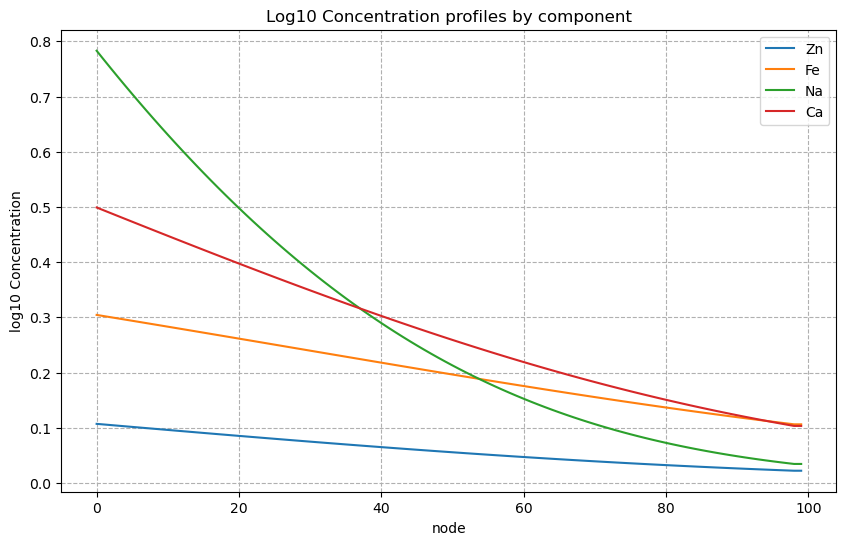

In [12]:
import matplotlib.pyplot as plt

# 각 농도별 log10 plot
plt.figure(figsize=(10, 6))
for i, comp in enumerate(components):
    plt.plot(range(N), (C_sol[i]), label=f'{comp}')
plt.xlabel('node')
plt.ylabel('log10 Concentration')
plt.title('Log10 Concentration profiles by component')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()
